Importing AfterImage Cython Library
Importing Scapy Library
counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Training Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[49]]
origional ids of the features
[[98, 91, 84, 70, 77]]
origional ids of the features
[[62, 59, 56, 50, 53]]
origional ids of the features
[[93, 86, 79, 65, 72]]
origional ids of the features
[[12, 43, 9, 36, 6, 29, 0, 15, 3, 22]]
origional ids of the features
[[95, 88, 81, 67, 74, 96, 89, 82, 68, 75]]
origional ids of the features
[[94, 87, 80, 66, 73]]
origional ids of the features
[[13, 44, 10, 37, 7, 30, 4, 23, 1, 16]]
origional ids of the features
[[97, 90, 83, 69, 76, 47, 40, 33, 19, 26]]
origional ids of the features
[[14, 45, 11, 38, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[46, 39, 32, 18, 25]]
origional ids of the features
[[63, 60, 57, 51, 54, 64, 61, 58, 52, 55]]
origional ids of the features
[[20, 48, 27, 34, 41]]
origion

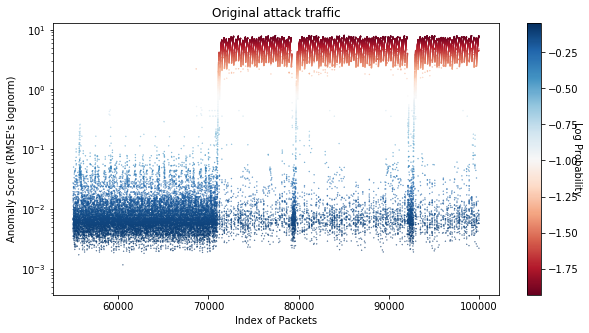

In [1]:
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture 
from Kitsune import Kitsune

%matplotlib inline
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

# File location
path = "100000_packets_mirai.tsv" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself) 

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

# Train Kitsune
print("Training Kitsune:")
RMSEs = []
i = 0
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
    
print('The feature extraction is complete. . .')
threshold = max(RMSEs[0: 69999])

labels = []     
y_all_blackbox = list([0]*(FMgrace + ADgrace + 1))
for line in open("100000_labels_mirai.tsv"): 
    if line.find('0') != -1: 
        labels.append(0)
    elif line.find('1') != -1: 
        labels.append(1)
        
positive_sum = 30001 
positive_num = 0
positive_train = int(positive_sum * 0.6)
train_num = 0
positive_validation = int(positive_sum * 0.2)
validation_num = 0
positive_test = positive_sum - positive_train - positive_validation
test_num = 0
vs_1 = 6001 * 1 
vs_2 = 6001 * 2 
vs_3 = 6001 * 3 
vs_4 = 6001 * 4 
vs_5 = min(6001 * 5, positive_sum) 
vs_1_num = 0
vs_2_num = 0
vs_3_num = 0
vs_4_num = 0
vs_5_num = 0
num = 0
FP = 0
print(positive_train)
print(positive_validation)
print(positive_test)
# threshold = 0
# for i in range(FMgrace + ADgrace + 1, 100000):
#     if labels[i] == 0:   
#         threshold = max(threshold,RMSEs[i])
for i in range(FMgrace + ADgrace + 1, 100000):
    if labels[i] == 0:
        if RMSEs[i] > threshold: 
            FP += 1
    elif labels[i] == 1:
        num += 1
        if RMSEs[i] > threshold: 
            positive_num += 1
            if num <= positive_train:
                train_num += 1
            elif num <= positive_train + positive_validation:
                validation_num += 1
            else:
                test_num += 1
            if num > positive_sum - vs_1:
                vs_1_num += 1
            if num > positive_sum - vs_2:
                vs_2_num += 1    
            if num > positive_sum - vs_3:
                vs_3_num += 1
            if num > positive_sum - vs_4:
                vs_4_num += 1    
            if num > positive_sum - vs_5:
                vs_5_num += 1 
    if RMSEs[i] > threshold:
        y_all_blackbox.append(1)
    elif RMSEs[i] <= threshold:
        y_all_blackbox.append(0)
original_TPR = positive_num / positive_sum
Precision = positive_num / (positive_num + FP)
F_score = 2 * original_TPR * Precision / (original_TPR + Precision)

train_TPR = train_num / positive_train
validation_TPR = validation_num / positive_validation
test_TPR = test_num / positive_test
print('Threshold: {0}'.format(threshold))
print('Original_TPR (Recall): {0:0.4f}'.format(original_TPR)) 
print('Precision: {0:0.4f}'.format(Precision)) 
print('F-score: {0:0.4f}'.format(F_score)) 
print('Train_TPR: {0:0.4f}  Validation_TPR: {1:0.4f}  Test_TPR: {2:0.4f}'.format(train_TPR, validation_TPR, test_TPR)) 
vs_1_TPR = vs_1_num / vs_1
vs_2_TPR = vs_2_num / vs_2
vs_3_TPR = vs_3_num / vs_3
vs_4_TPR = vs_4_num / vs_4
vs_5_TPR = vs_5_num / vs_5
print('vs_1_TPR: {0:0.4f}  vs_2_TPR: {1:0.4f}  vs_3_TPR: {2:0.4f}  vs_4_TPR: {3:0.4f}  vs_5_TPR: {4:0.4f}'.format(vs_1_TPR, vs_2_TPR, vs_3_TPR, vs_4_TPR, vs_5_TPR)) 
print(positive_num)
print(positive_sum)

# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample)) 

# plot the RMSE anomaly scores
print("Plotting results")
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdBu')
plt.yscale("log") 
plt.title("Original attack traffic")
plt.ylabel("Anomaly Score (RMSE's lognorm)")
plt.xlabel("Index of Packets")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
#plt.savefig("Mirai_kitsune_before.pdf")
plt.show()


In [1]:
########################################################################
# Put 100000*1.2 packets into kitsune for inspection
########################################################################

import time
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture 
from Kitsune import Kitsune

# File location
path = "130001_packets_mirai.tsv" 
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)  
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)  

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace) 

print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))
print('The feature extraction is complete. . .')

#threshold = max(RMSEs[0: 69999])
threshold = 2.202852374486657 

labels = []
for line in open("130001_labels_mirai.tsv"):  
    if line.find('0') != -1: 
        labels.append(0)
    elif line.find('1') != -1: 
        labels.append(1)
    elif line.find('2') != -1: # Represents the adversarial sample generated by GAN
        labels.append(2)



Importing AfterImage Cython Library
Importing Scapy Library
counting lines in file...
There are 130002 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Running Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[49]]
origional ids of the features
[[98, 91, 84, 70, 77]]
origional ids of the features
[[62, 59, 56, 50, 53]]
origional ids of the features
[[93, 86, 79, 65, 72]]
origional ids of the features
[[12, 43, 9, 36, 6, 29, 0, 15, 3, 22]]
origional ids of the features
[[95, 88, 81, 67, 74, 96, 89, 82, 68, 75]]
origional ids of the features
[[94, 87, 80, 66, 73]]
origional ids of the features
[[13, 44, 10, 37, 7, 30, 4, 23, 1, 16]]
origional ids of the features
[[97, 90, 83, 69, 76, 47, 40, 33, 19, 26]]
origional ids of the features
[[14, 45, 11, 38, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[46, 39, 32, 18, 25]]
origional ids of the features
[[63, 60, 57, 51, 54, 64, 61, 58, 52, 55]]
origional ids of the features
[[20, 48, 27, 34, 41]]
origiona

NameError: name 'gen_samples_num' is not defined

Threshold: 2.202852374486657
mal_TPR: 0 / 6001 = 0.0000
dis_TPR: 362 / 6001 = 0.0603
dis_mal_TPR: 362 / 12002 = 0.0302
MRR: 5252 - 0 / 5252 = 1.0000
Plotting results


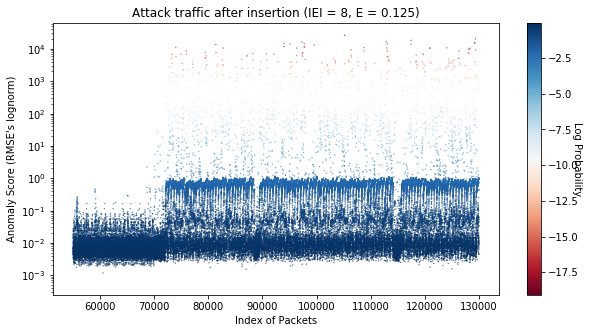

In [3]:
gen_samples_num = 6001 
IEI = 8
E = 1/IEI

mal_tot = min(gen_samples_num * int(E*IEI), 30001) 
dis_tot = gen_samples_num
dis_mal_tot = gen_samples_num * (int(E*IEI) + 1)
or_mal_tot = max(30001 - mal_tot, 0) 
mal_num = 0
dis_num = 0
dis_mal_num = 0
#or_mal_num = 0
num = 0
for i in range(FMgrace + ADgrace + 1, 100000 + gen_samples_num): 
    if labels[i] == 1 or labels[i] == 2:
        num += 1
        if RMSEs[i] > threshold: 
            if num >= or_mal_tot:
                dis_mal_num += 1
                if labels[i] == 1:
                    mal_num += 1
                else:
                    dis_num += 1

#or_mal_TPR = or_mal_num / or_mal_tot
mal_TPR = mal_num / mal_tot
dis_TPR = dis_num / dis_tot
dis_mal_TPR = dis_mal_num / dis_mal_tot
if int(E*IEI) == 1:
    origin_mal_num = 5252 
elif int(E*IEI) == 2:
    origin_mal_num = 10016 
elif int(E*IEI) == 3:
    origin_mal_num = 15324  
elif int(E*IEI) == 4:
    origin_mal_num = 20328  
elif int(E*IEI) == 5:
    origin_mal_num = 24559  
MRR = (origin_mal_num - mal_num) / origin_mal_num 
print('Threshold: {0}'.format(threshold))
#print('or_mal_TPR: {0} / {1} = {2:0.4f}'.format(or_mal_num,or_mal_tot,or_mal_TPR))
print('mal_TPR: {0} / {1} = {2:0.4f}'.format(mal_num,mal_tot,mal_TPR))
print('dis_TPR: {0} / {1} = {2:0.4f}'.format(dis_num,dis_tot,dis_TPR))
print('dis_mal_TPR: {0} / {1} = {2:0.4f}'.format(dis_mal_num,dis_mal_tot,dis_mal_TPR))
print('MRR: {0} - {1} / {2} = {3:0.4f}'.format(origin_mal_num,mal_num,origin_mal_num,MRR)) 
                
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample)) 

from matplotlib import pyplot as plt
# plot the RMSE anomaly scores
print("Plotting results")
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdBu')
plt.yscale("log") 
plt.title("Attack traffic after insertion (IEI = {0}, E = {1})".format(IEI,E))
plt.ylabel("Anomaly Score (RMSE's lognorm)")
plt.xlabel("Index of Packets")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).pdf".format(IEI,E))
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).eps".format(IEI,E))
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).png".format(IEI,E))
plt.show()
